In [ ]:
import tensorflow as tf
import torch
from torchvision import transforms
import numpy as np
import tensorflow_datasets as tfds

In [ ]:

# Load the dataset using TensorFlow
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_valid_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]']
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incomplete7ZWCFR/rock_paper_scissors-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incomplete7ZWCFR/rock_paper_scissors-test.tfrecord*...:   0%|         …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# Convert TensorFlow dataset to NumPy arrays
def tf_dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)



In [ ]:
class Binarize(object):
    def __call__(self, img):
        img = (img > 0.5).float()
        return img

In [ ]:
# Convert TensorFlow dataset to NumPy arrays
train_images, train_labels = tf_dataset_to_numpy(dataset_train_raw)
valid_images, valid_labels = tf_dataset_to_numpy(dataset_valid_raw)
test_images, test_labels = tf_dataset_to_numpy(dataset_test_raw)


In [ ]:

# Define transformations for PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28),
    transforms.Grayscale(),
     # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5], std=[0.5]),
    #Binarize()
])

# Apply transformations and convert to PyTorch tensors
train_images_tensor = torch.stack([transform(image) for image in train_images])
valid_images_tensor = torch.stack([transform(image) for image in valid_images])
test_images_tensor = torch.stack([transform(image) for image in test_images])

# Convert labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_labels)
valid_labels_tensor = torch.tensor(valid_labels)
test_labels_tensor = torch.tensor(test_labels)

# Now you can use train_images_tensor, valid_images_tensor, test_images_tensor,
# train_labels_tensor, valid_labels_tensor, test_labels_tensor with PyTorch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = TensorDataset(valid_images_tensor, valid_labels_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


In [ ]:

print(train_labels_tensor[59])
kk=train_images_tensor[59]
npimg = kk.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
import cv2
import torch
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(npimg,cmap="gray")
plt.pause(0.001)
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gzip


In [ ]:
class MiniLeNet(nn.Module):
    def __init__(self, init_weights):
        super(MiniLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3) #input28x28X1 output:26x26X3
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #input :26x26x3 ouput#
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3) #input:
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=False)
        self.fc = nn.Linear(75, 3)
        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():  # Returns an iterator over all modules in the network.
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)  # input(1, 28, 28) output(3, 26, 26)
        x = F.relu(x)
        x = self.pool1(x)          # output(3, 13, 13)
        x = self.conv2(x)  # output(3, 11, 11)
        x = F.relu(x)
        x = self.pool2(x)          # output(16, 5, 5)
        x = x.view(-1, 75)     # output(256)
        # conv1_result = x.cpu().detach().numpy().round()
        # print(conv1_result)
        x = self.fc(x)   # output(120)

        return x


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
import torch.nn as nn


import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
net=MiniLeNet(True)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
val_data_iter = iter(valid_loader)
val_image, val_label = next(val_data_iter)

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 14 == 13:  # print every 500 mini-batches
          with torch.no_grad():  # 不计算损失误差梯度 减少算力
              outputs = net(val_image)  # [batch, 10] 正向传播
              predict_y = torch.max(outputs, dim=1)[1]  # 维度一上面寻找最大值 网络预测最可能是哪个类别
              accuracy = torch.eq(predict_y, val_label).sum().item() / val_label.size(0)
              # accuracy = (predict_y == val_label).sum().item() / val_label.size(0)
              # torch.eq(predict_y, val_label)相同为True 不同为False ，sun()计算的是tensor数值，用item()转化为数值
              print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                    (epoch + 1, i + 1, running_loss / 15, accuracy))
              running_loss = 0.0

print('Finished Training')

In [ ]:
# num_epochs=20
# for epoch in range(num_epochs):


In [ ]:
params = net.parameters()

# Iterate through the parameters and print their shape and values
for param in params:
    print(param.shape)  # Print the shape of the parameter tensor
    print(param)        # Print the parameter tensor itself

In [ ]:
weights=net.parameters()
scaled_weights = [torch.round(param * 256) for param in weights]
#scaled_weights = [np.round(int(1)) for w in weights]
#scaled_weights = [np.round(w/w)  for w in weights]
print(scaled_weights)

In [ ]:
# Load the scaled and rounded parameters back into the model
with torch.no_grad():
    for param, scaled_rounded_param in zip(net.parameters(), scaled_weights):
        param.data.copy_(scaled_rounded_param.data)

In [ ]:
nparams = net.parameters()

# Iterate through the parameters and print their shape and values
for param in nparams:
    print(param.shape)  # Print the shape of the parameter tensor
    print(param)        # Print the parameter tensor itself

Sample Pridiction:

In [ ]:

print(test_labels_tensor[64])
kk=test_images_tensor[64]
npimg = kk.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
gg=np.round(kk*255)
import cv2
import torch
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(npimg,cmap="gray")
plt.pause(0.001)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# Assuming your CNN model is defined as "model"
# Assuming your image tensor is named "image_tensor"

# Make sure your model is in evaluation mode
net.eval()

# Pass the image tensor through the model
with torch.no_grad():
    outputs = net(gg)

# Apply softmax to get probabilities if your model output is logits
probabilities = F.softmax(outputs, dim=1)

# If you want to get the class predictions (indices with highest probability)
_, predicted_classes = torch.max(probabilities, 1)

# Convert tensor to integer
predicted_class = predicted_classes.item()
print(predicted_class)

0


In [ ]:
torch.save(net.state_dict(), "cnn")

In [ ]:
print(test_labels_tensor[9])
kk=test_images_tensor[9]
gg=np.round(kk*255)

In [ ]:
first_layer = net.conv1  # Assuming the first layer is named "conv1", adjust accordingly
sec_layer = net.conv2
# Pass the image tensor through the first layer
with torch.no_grad():
    first_layer_output = first_layer(gg)
    first_layer_output = F.relu(first_layer_output)
    pool1_out=net.pool1(first_layer_output)
    sec_layer_ouput = sec_layer(pool1_out)
    sec_layer_ouput = F.relu(sec_layer_ouput)
    pool2_out=net.pool2(sec_layer_ouput)
    fc_in=pool2_out.view(-1,75)
    fc_out=net.fc(fc_in)



In [ ]:
fc_out.shape

torch.Size([1, 3])

In [ ]:
# Print each channel separately
def printLayerr(tensor_array):
  for channel in range(tensor_array.shape[0]):
      print("Channel:", channel)
      for row in range(tensor_array.shape[1]):

          for col in range(tensor_array.shape[2]):
              print(tensor_array[channel,row, col], end=" ")
          print()  # Newline after each row
      print()  # Newline after each channel

In [ ]:
print(fc_out)

tensor([[ 2.5056e+09, -1.7253e+09, -1.6819e+09]])


In [ ]:
printLayerr(pool2_out.numpy())

In [ ]:
#print(first_layer_output)

In [ ]:
import numpy as np

# image
matrix1 = np.array([[0.9998, 0.9998, 0.9998],
                    [0.9998, 0.9998, 0.9998],
                    [0.9997, 0.9998, 0.9998]])
matrix1=np.round(255*matrix1)
#weight
matrix2 = np.array([[107, 43, 152],
                    [-141, -91, 122],
                    [21, -93, -138]])

# Perform the convolution
convolution_result = 0

for i in range(3):
    for j in range(3):
        convolution_result = convolution_result+matrix1[i][j]*matrix2[i][j]
        #print(matrix1[i][j],matrix2[i][j],matrix1[i][j]*matrix2[i][j])

print("Convolution result:")
#print(convolution_result)
print(convolution_result+23)


Convolution result:
-4567.0


**Saving weights**

In [ ]:

nparams = net.parameters()
######################################## CONV 1 #############################################
f = open("conv1.txt", "w")
f.write("######### conv1 weights #########\n")
para = list(nparams)
conv1_w=para[0].detach().numpy()
for i in range(len(conv1_w)):
  arr=conv1_w[i][0]
  for w in arr:
    w1="10'd"+str(int(w[0])) if w[0]>0 else "-10'd"+str(abs(int(w[0])))
    w2="10'd"+str(int(w[1])) if w[1]>0 else "-10'd"+str(abs(int(w[1])))
    w3="10'd"+str(int(w[2])) if w[2]>0 else "-10'd"+str(abs(int(w[2])))
    f.write("{},{},{}\n".format(w1,w2,w3))
  f.write('---------\n')
  # print(para[0].detach().numpy()[1][0])
  # print(para[0].detach().numpy()[2][0])

f.write("######### conv1 bias #########\n")
b=para[1].detach().numpy()
b1="10'd"+str(int(b[0])) if b[0]>0 else "-10'd"+str(abs(int(b[0])))
b2="10'd"+str(int(b[1])) if b[1]>0 else "-10'd"+str(abs(int(b[1])))
b3="10'd"+str(int(b[2])) if b[2]>0 else "-10'd"+str(abs(int(b[2])))
f.write("{},{},{}\n".format(b1,b2,b3))
f.close()





In [ ]:

nparams = net.parameters()
######################################## CONV 2 #############################################
f = open("conv2.txt", "w")
f.write("######### conv2 weights #########\n")
para = list(nparams)
temp=para[2].detach().numpy()
#print(temp)
#print("####")
for k in range(3):
  for j in range(3):
    conv2_w=temp[k][j]
    #print(conv2_w)
    #print('--------')
    for i in range(3):
      w=conv2_w[i]
      #print(w)

      w1="10'd"+str(int(w[0])) if w[0]>0 else "-10'd"+str(abs(int(w[0])))
      w2="10'd"+str(int(w[1])) if w[1]>0 else "-10'd"+str(abs(int(w[1])))
      w3="10'd"+str(int(w[2])) if w[2]>0 else "-10'd"+str(abs(int(w[2])))
      f.write("{},{},{}\n".format(w1,w2,w3))
    f.write('---------\n')
      # print(para[0].detach().numpy()[1][0])
      # print(para[0].detach().numpy()[2][0])

f.write("######### conv2 bias #########\n")
b=para[3].detach().numpy()*65536
print(b)
b1="10'd"+str(int(b[0])) if b[0]>0 else "-10'd"+str(abs(int(b[0])))
b2="10'd"+str(int(b[1])) if b[1]>0 else "-10'd"+str(abs(int(b[1])))
b3="10'd"+str(int(b[2])) if b[2]>0 else "-10'd"+str(abs(int(b[2])))
f.write("{},{},{}\n".format(b1,b2,b3))
f.close()



[196608.     -0.  65536.]


In [ ]:
def dec2bnr(dec: int, lenth: int = 19) -> str:
    if not isinstance(dec, int):
        raise TypeError("输入非十进制整数！")
    # 计算十进制转化为二进制后的位数
    digits = (len(bin(dec)) - 3) if dec < 0 else (len(bin(dec)) - 2)
    if digits >= lenth:
        raise OverflowError("输入十进制整数过大，超过指定补码长度")
    # Note: dec & 相同位数的0b111...强制转换为补码形式
    pattern = f"{dec & int('0b' + '1' * lenth, 2):0{lenth}b}"
    return ",".join(code for code in pattern)

In [ ]:
######################################## fully connected #############################################
nparams = net.parameters()
f = open("fc.txt", "w")
f.write("###### fc weights ######## \n")
para = list(nparams)
temp=para[4].detach().numpy()
for i in range(75):
  #print(temp[0][i],temp[1][i],temp[2][i])
  w1=dec2bnr(int(temp[0][i]),10).replace(',', '')
  w2=dec2bnr(int(temp[1][i]),10).replace(',', '')
  w3=dec2bnr(int(temp[2][i]),10).replace(',', '')
  f.write("{}{}{},\n".format(w1,w2,w3))
  #print(w1,w2,w3)

f.write("\n")
f.write("###### fc bias ######## \n")
b=para[5].detach().numpy()
b1="10'd"+str(int(b[0])) if b[0]>0 else "-10'd"+str(abs(int(b[0])))
b2="10'd"+str(int(b[1])) if b[1]>0 else "-10'd"+str(abs(int(b[1])))
b3="10'd"+str(int(b[2])) if b[2]>0 else "-10'd"+str(abs(int(b[2])))
f.write("{},{},{}\n".format(b1,b2,b3))

f.close()
# print(temp)

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import numpy as np
# import tensorflow as tf
# # Load an RGB image
# image = cv2.imread('p2.JPG')
# # Convert to grayscale
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# resized_image = cv2.resize(gray_image, (28,28))
# #normalized_image = resized_image / 255.0 #QUESTION?????????
# cv2_imshow(resized_image)

**GET IMAGE data for testbenches**

tensor(1)


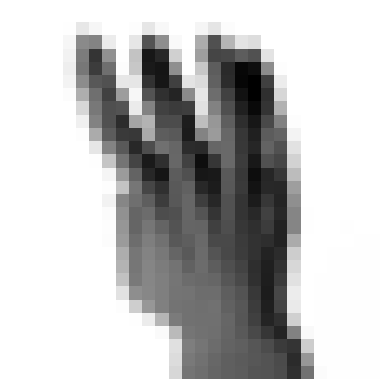

In [ ]:

print(test_labels_tensor[8])
kk=test_images_tensor[8]
npimg = kk.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
import cv2
import torch
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(npimg,cmap="gray")
plt.pause(0.001)
plt.show()
gg=np.round(kk*255)
sample=gg.numpy()
#print(sample[0])

In [ ]:


eight_bit_values = [bin(int(pixel)) for p in sample[0] for pixel in p ]
result=[]
for e in eight_bit_values:
  _,n=e.split('b')
  #print(n)
  result.append(n)
print(result)
with open("rock1.txt", "w") as f:
    for value in result:
        f.write(str(value) + "\n")

['11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11

[[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 240. 216. 233. 254. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 245. 160. 107. 117. 227. 235.
  234. 252. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 254. 255. 229. 146. 117.  87. 127.  92.
   96. 206. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 254. 221. 165. 171. 197. 150. 124.  88.  60.  48.
   73. 137. 249. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 246. 154. 101.  69.  86. 144. 128.  86.  61.  47.
   88.  94. 148. 190. 249. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 245. 160. 116.  74.  67. 137. 132.  90.  66.  46.
   95.  82.  71.  78. 165. 251. 255. 255. 255. 255. 255. 2

['11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11110000', '11011000', '11101001', '11111110', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11110101', '10100000', '1101011', '1110101', '11100011', '11101011', '11101010', '11111100', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '11111111', '1111

In [ ]:
torch.save(net.state_dict(), "cnn")

In [ ]:
class MiniLeNet(nn.Module):
    def __init__(self, init_weights):
        super(MiniLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=False)
        self.fc = nn.Linear(75, 3)
        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():  # Returns an iterator over all modules in the network.
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # 对卷积权重W初始化
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)  # 正态分布对W赋值
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)  # input(1, 28, 28) output(3, 26, 26)
        x = F.relu(x)
        x = self.pool1(x)          # output(3, 13, 13)
        x = self.conv2(x)  # output(3, 11, 11)
        x = F.relu(x)
        x = self.pool2(x)          # output(16, 5, 5)
        x = x.view(-1, 75)     # output(256)
        # conv1_result = x.cpu().detach().numpy().round()
        # print(conv1_result)
        x = self.fc(x)   # output(120)

        return x


In [ ]:
model = MiniLeNet(True)
model.load_state_dict(torch.load("cnn"))
model.eval()

MiniLeNet(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=75, out_features=3, bias=True)
)